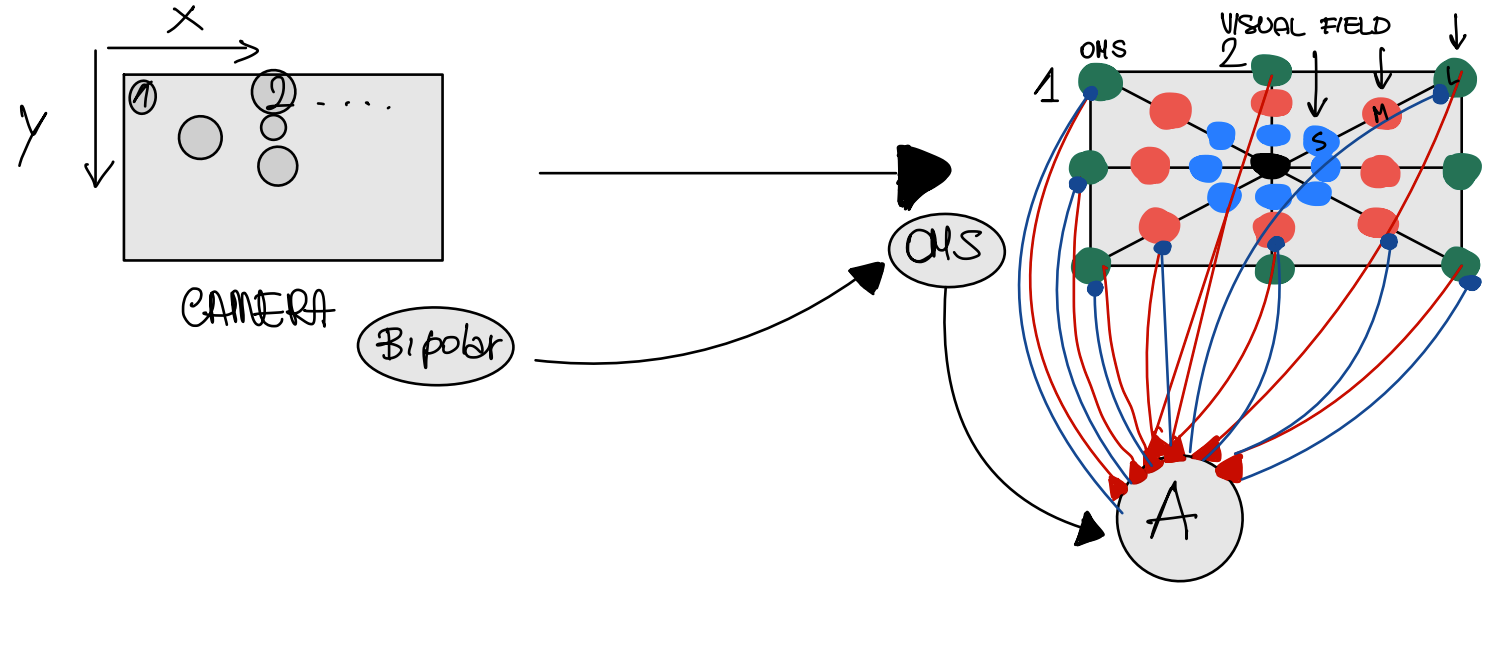

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import random
from tempfile import TemporaryFile
import time
import os

In [3]:
from brian2 import *
from brian2tools import *
%matplotlib inline

In [5]:
matplotlib.use('TkAgg')

width = 3
height = 3

t = np.arange(0, 1, 0.1)  # s
pol = 1
events_percentage = 75  # % percentage of the total number of possible events to occur at each timestamp
num_events = round(height * width * events_percentage / 100)  # number of occurring events at each timestamp

events = {"x": [], "y": [], "ts": [], "pol": [], "idx": []}
frame = np.zeros((width, height))
coordinates = np.zeros((width * height, 2), dtype=int)  # list of all pixel coordinates
idx = 0
for x in np.arange(width):
    for y in np.arange(height):
        coordinates[idx][0] = x
        coordinates[idx][1] = y
        idx += 1

# plt.figure()
for ts in t:
    coor_idx = np.random.choice(len(coordinates), size=num_events, replace=False)
    coor_sample = coordinates[coor_idx]
    for i in np.arange(len(coor_sample)):
        # events is a list of tuples: (x position, y position, time in seconds, on/off polarity)
        # creating events
        # x
        events['x'].append(coor_sample[i][0])
        # y
        events['y'].append(coor_sample[i][1])
        # ts
        events['ts'].append(ts)
        # pol
        events['pol'].append(pol)
        # idx
        events['idx'].append(coor_sample[i][0] * height + coor_sample[i][1])
        frame[coor_sample[i][1], coor_sample[i][0]] = 1

# Visualization
    # plt.imshow(frame)
    # plt.draw()
    # plt.pause(0.1)
    # frame = np.zeros((width, height))

In [6]:
# events = np.load("events.npy", allow_pickle='TRUE').item()

start_scope()

# Spike generator group simulating bipolar (BP) cells aka the events
idxs = array(events['idx'])
times = array(events['ts'])*second
width = 3
height = 3
N = width*height # The placement of the neurons are to cover the full visual field equally. Therefore, depending on the angle you can
# displace the number of neurons you want on each angle.
BP = SpikeGeneratorGroup(N, events['idx'], events['ts']*second)


# # NeuronGroup for creating OMS cells
# # LIF neuron
# # (unless refractory) to add if a refractory period is defined in NeuronGroup
eqs = '''
dv/dt = (I-v)/tau : 1  
I : 1
tau : second
'''

OMS = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', method='exact') # Adding a threshold and the reset to 0 after a spike. (to add RP : refractory = 3*ms)
OMS.tau = [10]*ms

# # Creating the synapse between BP and OMS
S_BP_OMS = Synapses(BP, OMS, on_pre='v_post +=1.1')
S_BP_OMS.connect(i='j')

# Visualizing connectivity
def visualise_connectivity(S_BP_OMS):
    Ns = len(S_BP_OMS.source)
    Nt = len(S_BP_OMS.target)
    figure(figsize=(25, 8))

    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S_BP_OMS.i, S_BP_OMS.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['OMS', 'A'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))

figure()
visualise_connectivity(S_BP_OMS)


# NeuronGroup for creating a single Amacrine Cell (A)
A_thr = 0.70* N 
A = NeuronGroup(1, eqs, threshold='v>A_thr', reset='v=0', method='exact')  # refractory=3*ms
# Setting the input for the cells.
A.I = 0
# Setting the time constant
A.tau = 10 * ms

# Excitation synapses from BP cells to the A cell
S_OMS_A = Synapses(OMS, A, on_pre='v_post =0')
S_OMS_A.connect()

# Inhibitory synapse from A cell to the OMS_output cell
S_A_OUT = Synapses(A, OMS, on_pre='v_post -=1')
S_A_OUT.connect()


OMS_spike_mon = SpikeMonitor(OMS) # Recording spikes
OMS_rate_mon = PopulationRateMonitor(OMS) # Recording IFR, averaged across the neurons of the group 
OMS_state_mon = StateMonitor(OMS, 'v', record = True) # Recording state variable v during a run

A_spike_mon = SpikeMonitor(A) # Recording spikes
# # A_rate_mon = PopulationRateMonitor(OMS) # Recording IFR, averaged across the neurons of the group 
A_state_mon = StateMonitor(A, 'v', record = True) # Recording state variable v during a run

OMS_out_spike_mon = SpikeMonitor(A) # Recording spikes
# # A_rate_mon = PopulationRateMonitor(OMS) # Recording IFR, averaged across the neurons of the group 
OMS_out_state_mon = StateMonitor(A, 'v', record = True) # Recording state variable v during a run



run(1*second)

figure()
brian_plot(OMS_spike_mon)
plot(markersize=0.05)
title('OMS spikes')

# figure()
# brian_plot(OMS_rate_mon)

figure()
# for i in arange(N):
plot(OMS_state_mon.t/ms, OMS_state_mon.v[1], label='OMS ' + str(0))
xlabel('Time (ms)')
ylabel('V (volt)')
legend()
title('OMS voltage')

figure()
brian_plot(A_spike_mon)
plot(markersize=0.05)
title('A spikes')

figure()
plot(A_state_mon.t/ms, A_state_mon.v[0], label='A')
xlabel('Time (ms)')
ylabel('V (volt)')
legend()
title('A voltage')





WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


Text(0.5, 1.0, 'A voltage')

: 